# Experimentation

## Dataset profiling

In [1]:
%matplotlib inline
import random
import math
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np

import soli_start
from reviews_soli import ReviewsSolicitation
from data_model import Feature
import uncertainty

file_path = 'datasets/edmunds_reviews.csv'
dataset_profile = soli_start.probe_dataset(file_path)
print(dataset_profile)

Dataset of 5 stars, with 501 products and 53440 reviews
average of feature_rating_count/product = 77.766



Statistics of #reviews/product: min=1, max=1294, average=106.667, std=148.622, median=52.0


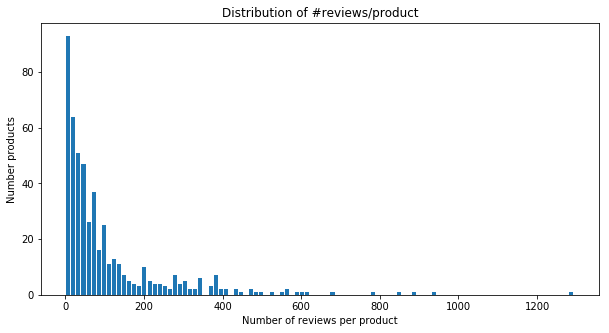

In [2]:
# Distribution of #reviews/product
temp = dataset_profile.per_product_review_counts
print('Statistics of #reviews/product: min={min}, max={max}'
      ', average={average:.3f}, std={std:.3f}, median={median}' \
      .format(min=np.amin(temp), max=np.amax(temp),
              average=np.average(temp), std=np.std(temp), median=np.median(temp)))

fig, ax = plt.subplots(figsize=(10, 5))
_ = ax.hist(dataset_profile.per_product_review_counts, bins=100, rwidth=0.8)
ax.set_xlabel('Number of reviews per product')
ax.set_ylabel('Number products')
ax.set_title('Distribution of #reviews/product')
plt.show()

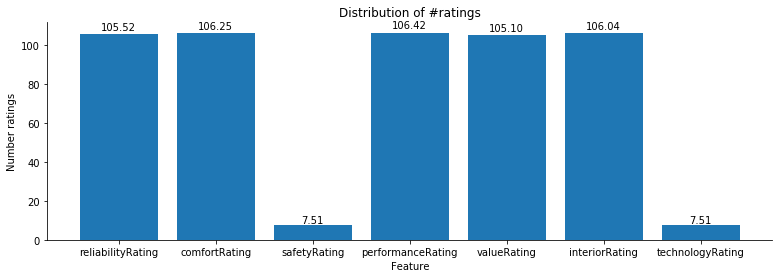

In [3]:
# Distribution of #feature_rating/product
fig, ax = plt.subplots(figsize=(13, 4))
features = list(dataset_profile.feature_to_review_count_average.keys())
num_ratings = list(dataset_profile.feature_to_review_count_average.values())
x_pos = np.arange(len(features))
rects = ax.bar(x_pos, num_ratings)

ax.set_xlabel('Feature')
ax.set_ylabel('Number ratings')
ax.set_title('Distribution of #ratings')
ax.set_xticks(x_pos)
ax.set_xticklabels(features)

for rect, num_rating in zip(rects, num_ratings):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., 1.01*height,
            '{:.2f}'.format(num_rating), ha='center', va='bottom')
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

## Simulation

------------------------output/edmunds_l500_p400_q3.pickle------------------------



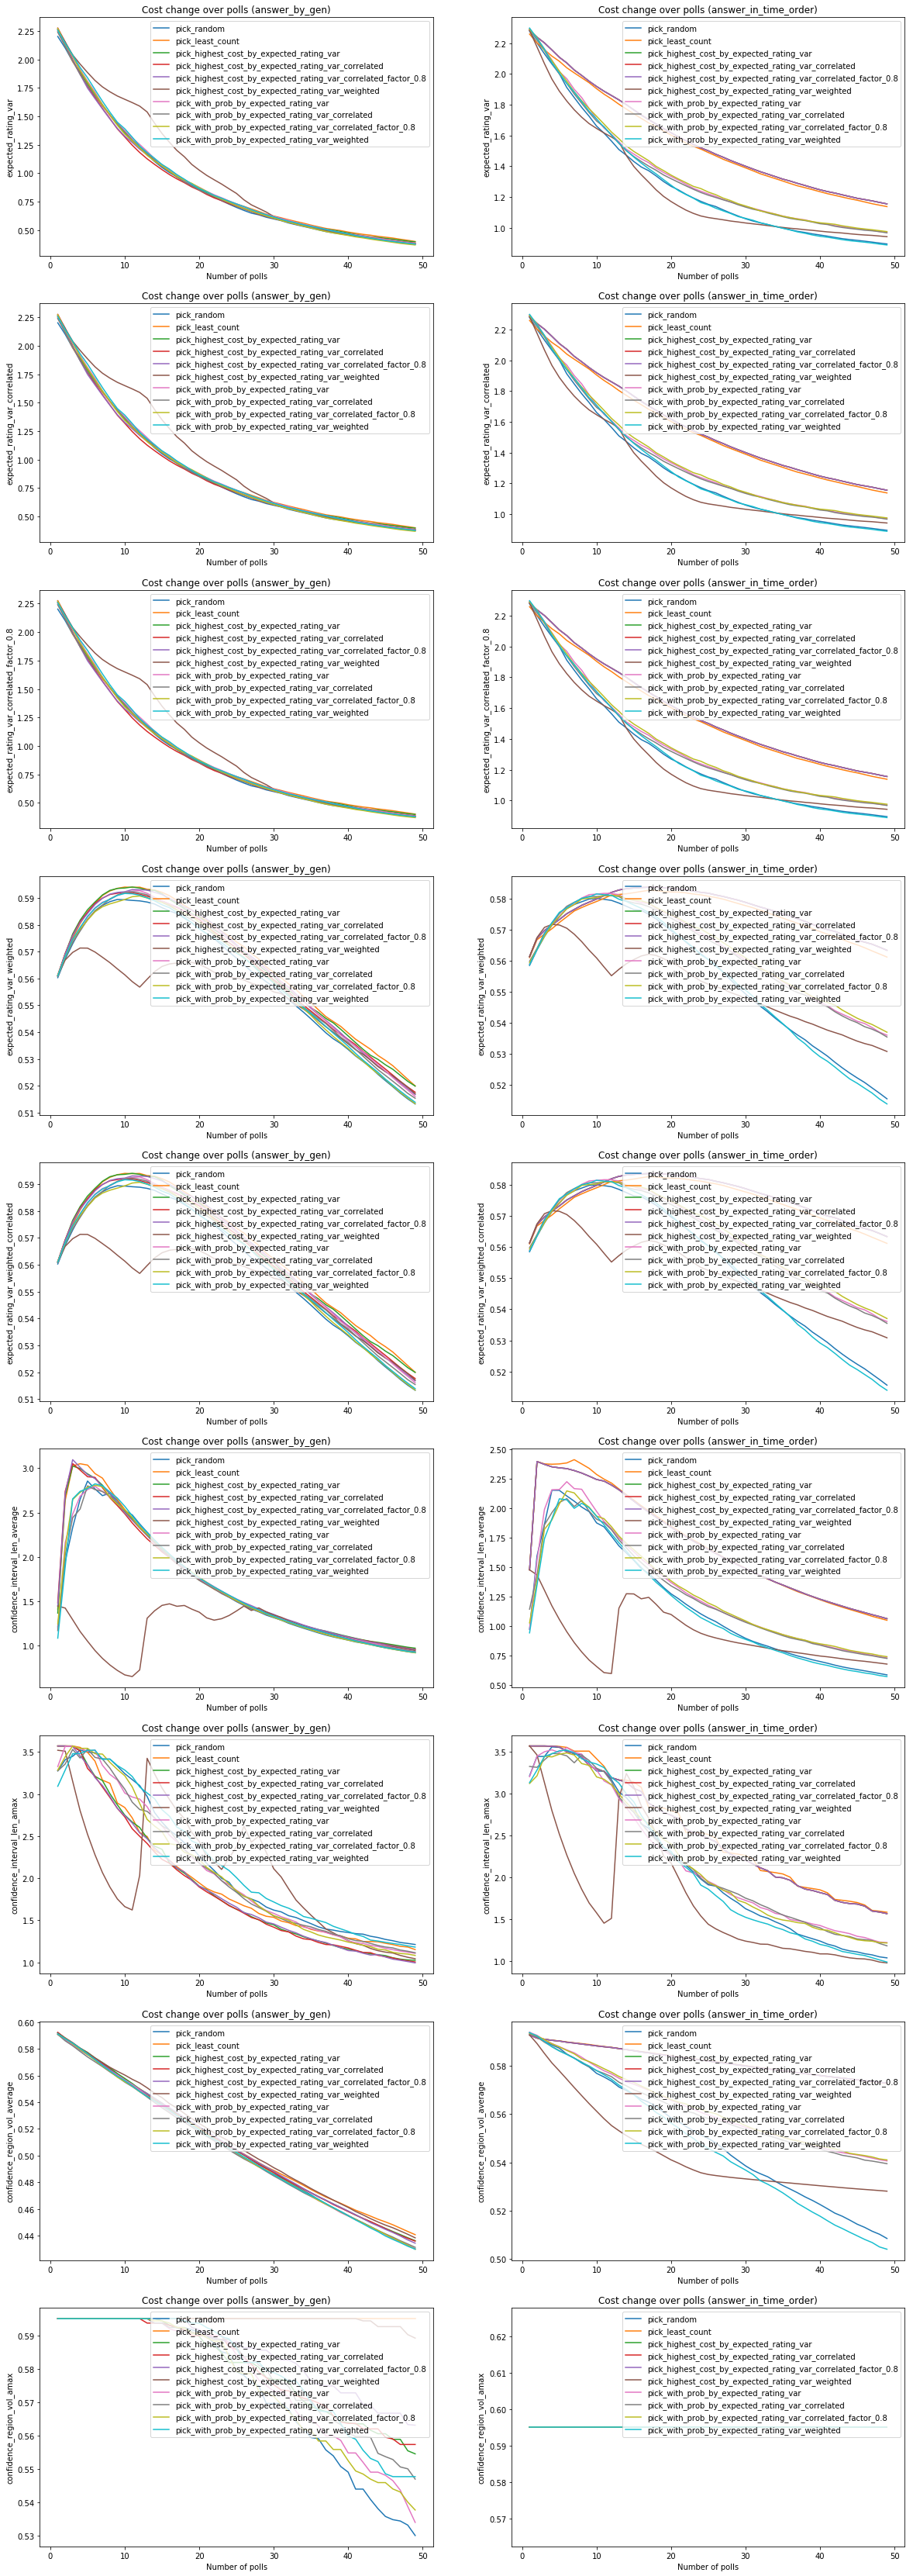

------------------------Rating distribution------------------------



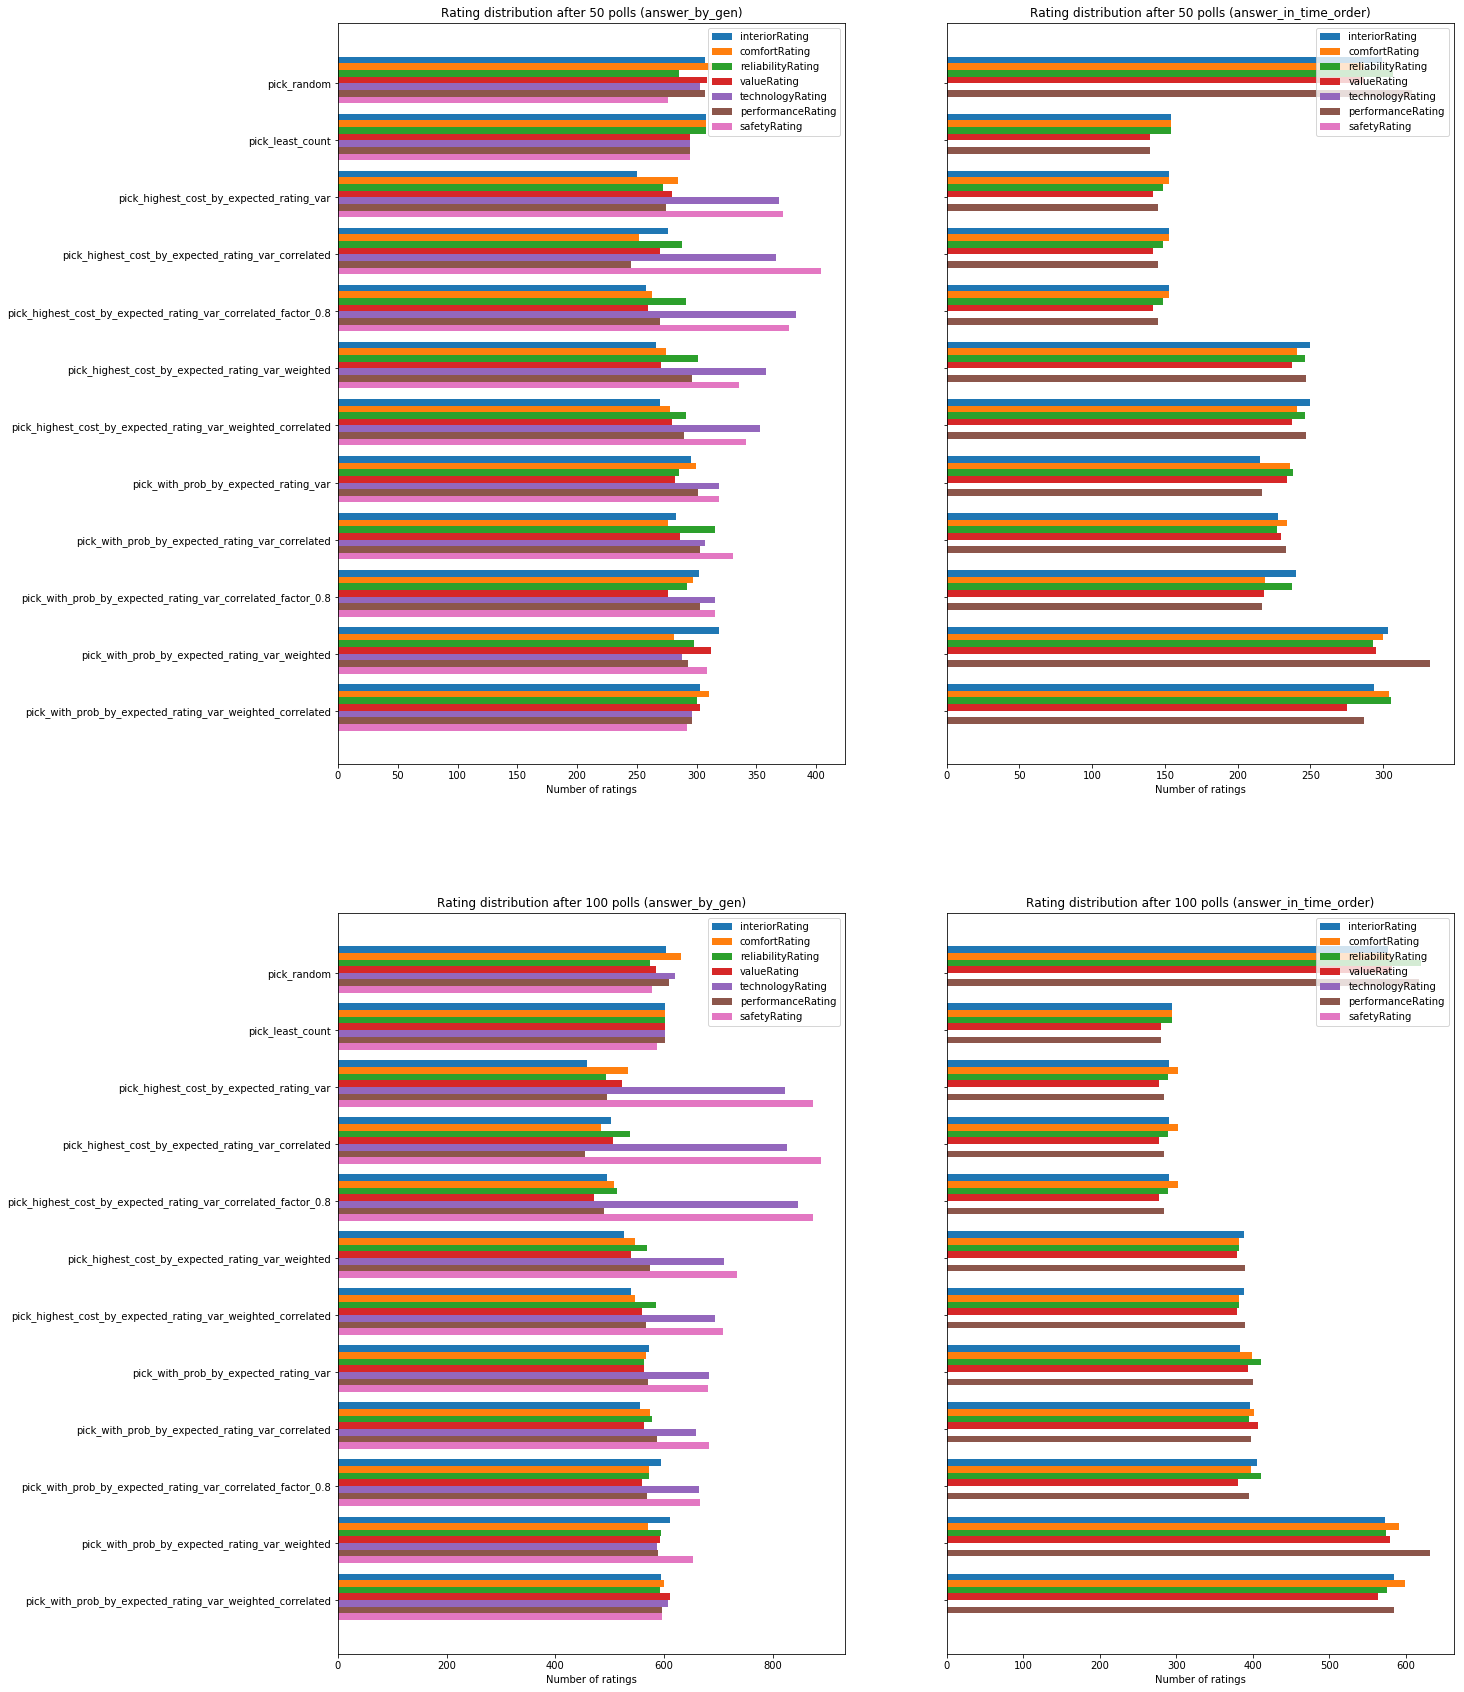

------------------------output/edmunds_l500_p400_q3_dup.pickle------------------------



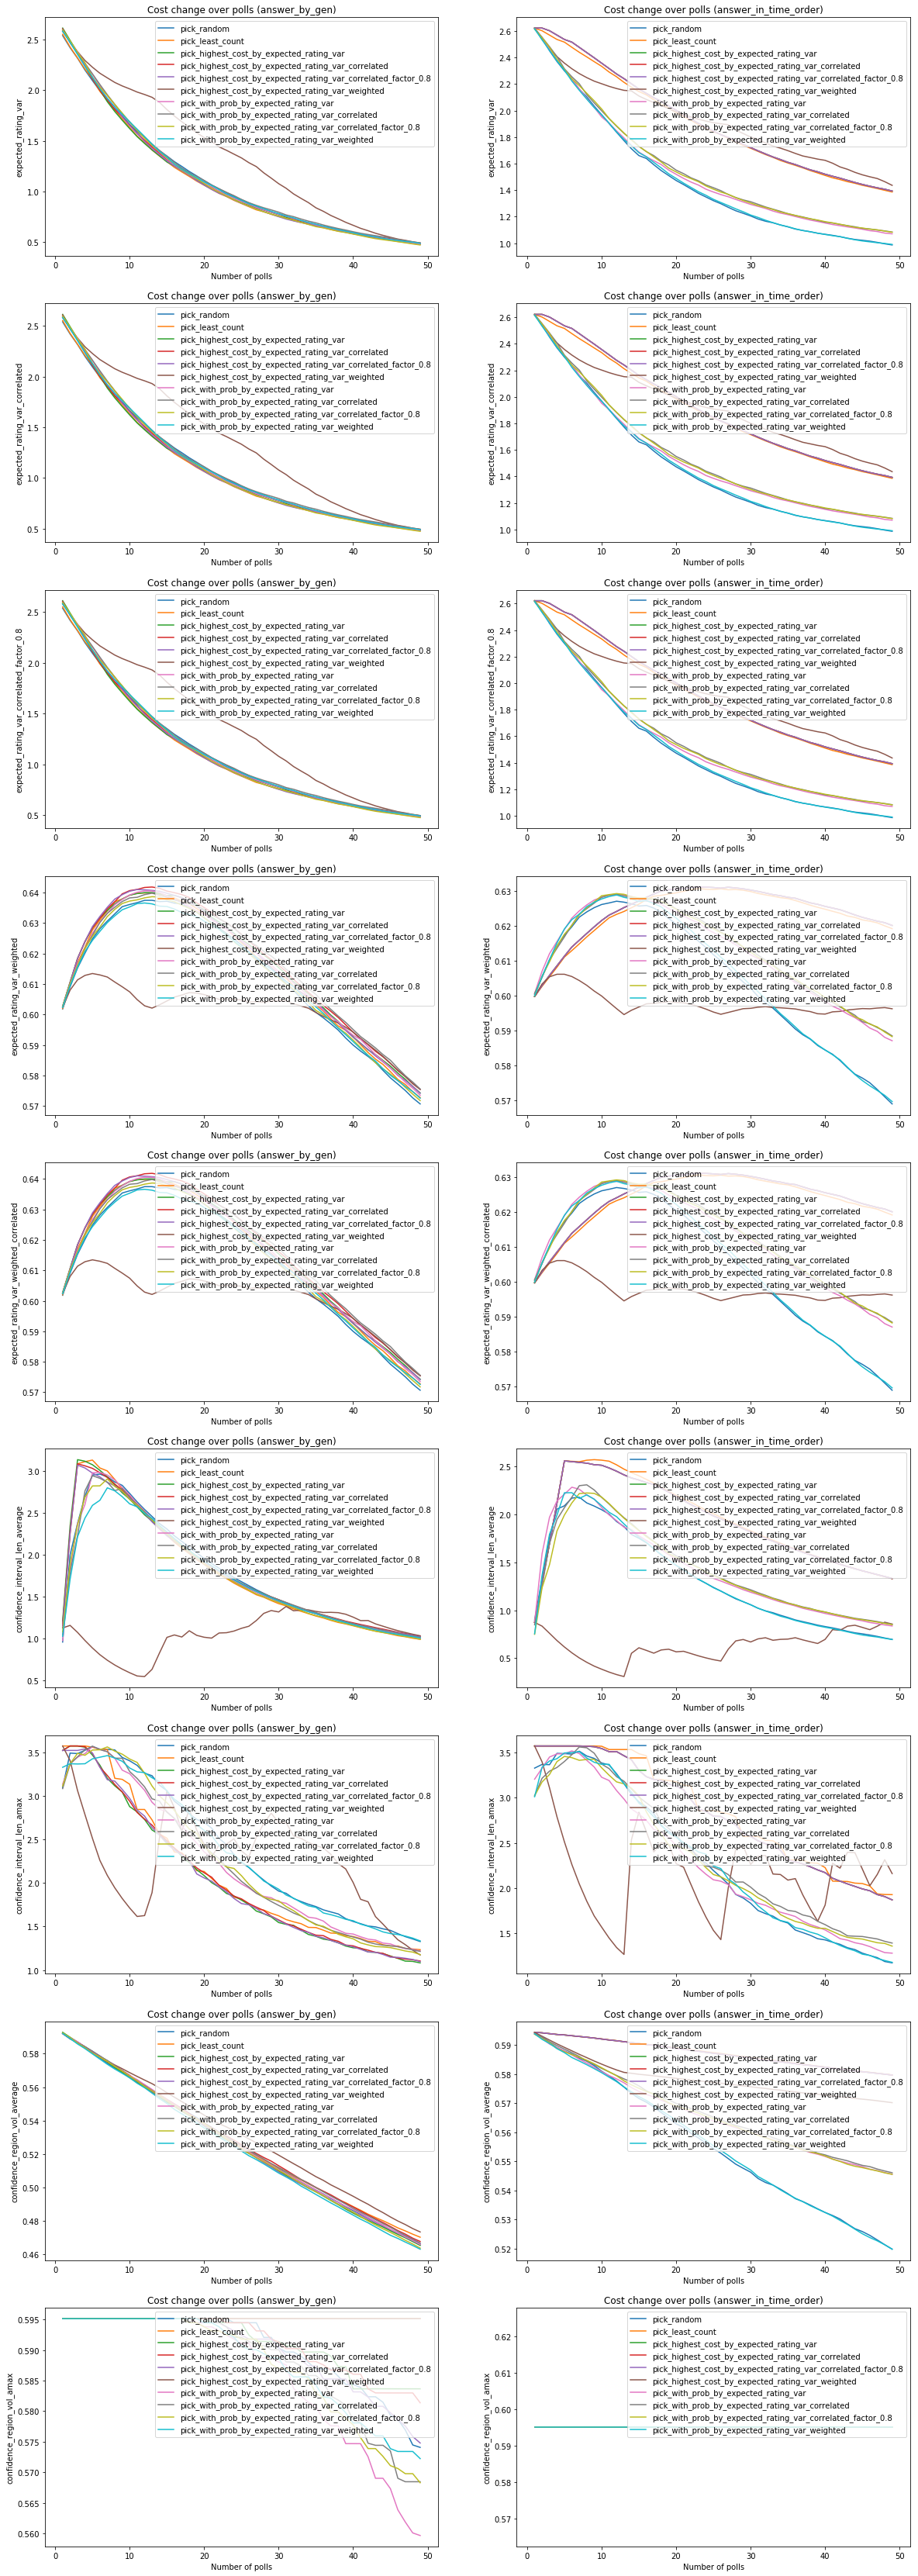

------------------------Rating distribution------------------------



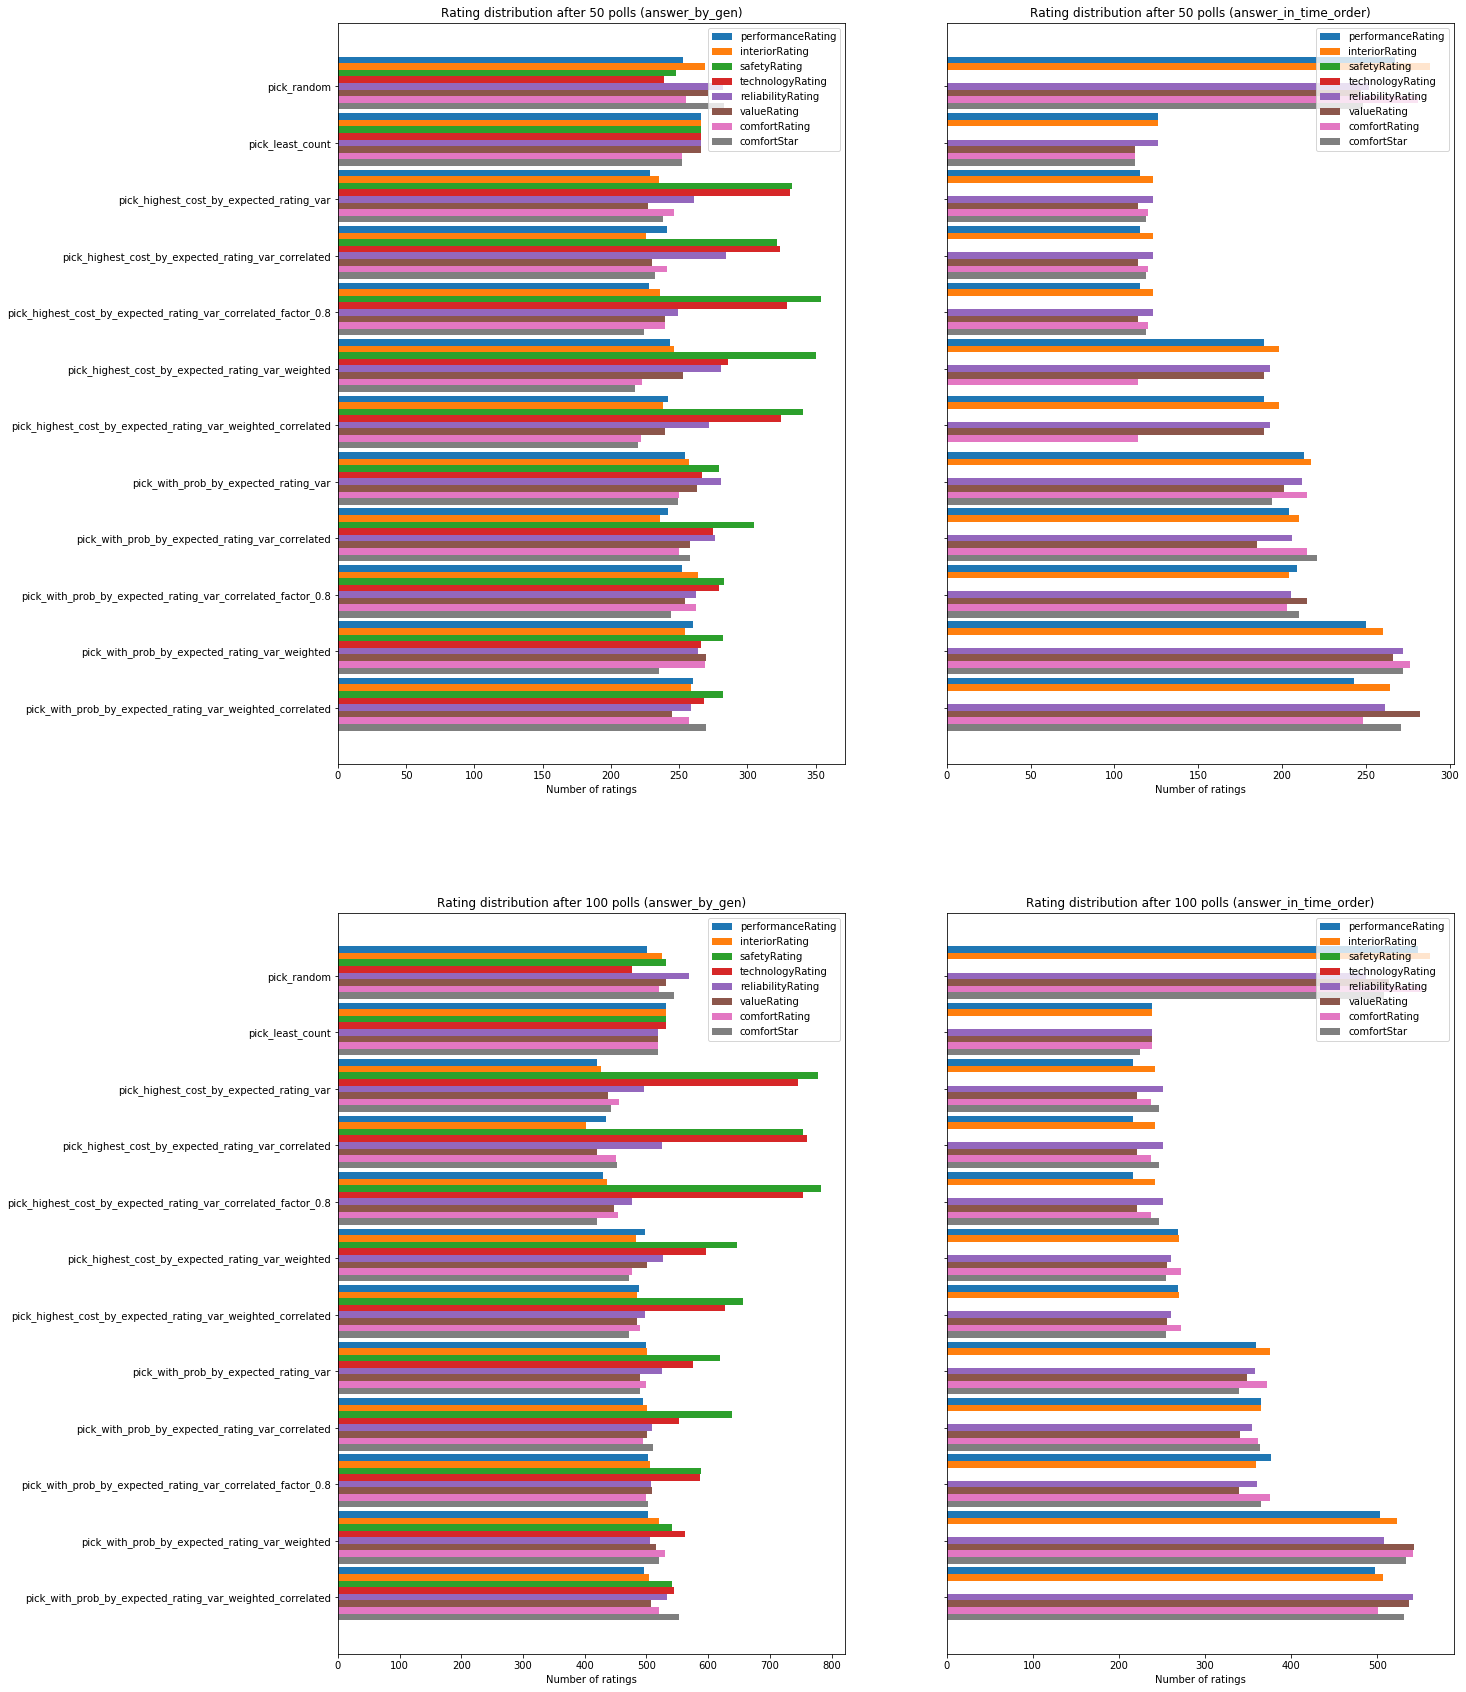

In [5]:
from uncertainty import UncertaintyMetric


def partition_goal_by_answer(goal_to_value):
    answer_to_goal_values = OrderedDict()
    for goal, value in goal_to_value.items():
        if goal.answer not in answer_to_goal_values:
            answer_to_goal_values[goal.answer] = OrderedDict()
        answer_to_goal_values[goal.answer][goal] = value

    return answer_to_goal_values


def plot_pick_answer_goals(goal_to_stats_average, poll_max=100,
                           fig_w=20, fig_h=50):
    """
    Args:
        goal_to_stats_average: SoliConfig -> SimulationStats
    """
    stats_sample = list(goal_to_stats_average.values())[0]
    metrics = UncertaintyMetric.metrics()
    markers = ['o', '^', '>', 's', 'd', '*', 'x', '1', '2', '+']

    X = list(stats_sample.polls)[1:poll_max]
    fig, axarr = plt.subplots(len(metrics), 2, figsize=(fig_w, fig_h),
                              subplot_kw=dict(xlabel='Number of polls'))
    
    answer_to_goal_stats = partition_goal_by_answer(goal_to_stats_average)
    for metric_idx, metric in enumerate(metrics):
        answer_idx = 0
        for answer, goal_to_stats_average in answer_to_goal_stats.items():
            # each goal is plotted by a curve
            for goal, stats in goal_to_stats_average.items():
                ax = axarr[metric_idx, answer_idx]
                if goal.optm_goal \
                        and goal.optm_goal not in UncertaintyMetric.optm_goals()[:-1]:
                    continue
                Y = [report.get_metric(metric)
                     for report in stats.uncertainty_reports[1:poll_max]]
                ax.plot(X, Y, label=goal.pick_goal_str())
                
                ax.set_title('Cost change over polls ({})'.format(answer))
                ax.set_ylabel(str(metric))
                ax.legend(loc='upper right')
            answer_idx += 1

    plt.show()


def plot_ratings(goal_to_stats_average, polls=[50, 100], fig_w=20, fig_h=20):

    fig, axarr = plt.subplots(len(polls), 2,
                              figsize=(fig_w, fig_h), sharey=True,
                              subplot_kw=dict(xlabel='Number of ratings'))

    features = list(goal_to_stats_average.values())[0].features
    Y = np.arange(len(goal_to_stats_average) / 2, 0, -1) * 6
    width = 0.7

    answer_to_goal_stats = partition_goal_by_answer(goal_to_stats_average)
    for poll_idx, poll in enumerate(polls):
        answer_idx = 0
        for answer, goal_to_stats in answer_to_goal_stats.items():
            ax = axarr[poll_idx, answer_idx]
            # plot each goal's stats by a set of horizontal bars
            for feature in features:
                X = [np.sum(stats_average.poll_to_ratings[poll][feature.idx, :])
                     for stats_average in goal_to_stats.values()]
                
                Y_pos = Y - feature.idx * width
                ax.barh(Y_pos, X, width, label=feature.name)

            Y_pos_mid = Y - len(features) / 2 * width
            ax.set_yticks(Y_pos_mid)
            ax.set_yticklabels([goal.pick_goal_str()
                                         for goal in goal_to_stats.keys()])
            ax.set_title("Rating distribution after {} polls ({})".format(
                poll, answer))
            ax.legend(loc='upper right')
            answer_idx += 1

    plt.show()


def plot_no_answer_count(pick_answer_to_sim_stats):
    no_answer_counts = [
        stat.no_answer_count for stat in pick_answer_to_sim_stats.values()
    ]
    fig, ax = plt.subplots(
        figsize=(6, 3),
        subplot_kw={'title': 'No answer count',
                    'xlabel': '#No answer'})
    y_pos = np.arange(len(pick_answer_to_sim_stats))
    rects = ax.barh(y_pos, no_answer_counts, align='center')

    ax.set_yticks(y_pos)
    ax.set_yticklabels([
        pick_method + ' - ' + answer_method
        for pick_method, answer_method in pick_answer_to_sim_stats.keys()
    ])

    for rect, count in zip(rects, no_answer_counts):
        ax.text(rect.get_x() + rect.get_width() + 10,
                rect.get_y() + rect.get_height() / 2,
                count, ha='left', va='center')
    plt.show()


import pickle
import soli_start

# sim_result_paths = ['output/result_duplicate.pickle', 'output/result.pickle']
sim_result_paths = ['output/edmunds_l500_p400_q3.pickle', 'output/edmunds_l500_p400_q3_dup.pickle']
for sim_result_path in sim_result_paths:
    print('------------------------{}------------------------\n'.format(sim_result_path))
    with open(sim_result_path, 'rb') as f:
        product_to_config_stats = pickle.load(f)

    goal_to_stats_average = soli_start.summary_product_to_config_stats(
        product_to_config_stats)
    plot_pick_answer_goals(goal_to_stats_average, poll_max=50, fig_h=60)
    
    print('------------------------Rating distribution------------------------\n')
    plot_ratings(goal_to_stats_average, polls=[50, 100], fig_h=30)